In [1]:
from time import time
import os
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.codification_skipc import ChromosomeSkip, FitnessSkip, Connections
from utils.datamanager import DataManager
from utils.lr_finder import LRFinder
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import Input, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Conv2D, PReLU, LeakyReLU, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.layers.merge import concatenate

from utils.utils import smooth_labels, WarmUpCosineDecayScheduler, LinearDecayScheduler

def show_result(history, metric='acc'):
        color = np.array([[31, 119, 180], [255, 127, 14]]) / 255.
        try:
            epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
            argmax_val = np.argmax(history.history['val_%s' % metric])
            plt.plot(epochs, history.history['val_%s' % metric], label='validation', color=color[0], alpha=0.5)
            plt.plot(epochs, median_filter(history.history['val_%s' % metric]), color=color[0])
            plt.scatter(epochs[argmax_val], history.history['val_%s' % metric][argmax_val],
            label='max val_%s %0.4f' % (metric, history.history['val_%s' % metric][argmax_val]), c='r')
        except KeyError:
            pass
        plt.plot(epochs, history.history[metric], label='train', color=color[1], alpha=0.5)
        plt.plot(epochs, median_filter(history.history[metric]), color=color[1])


        plt.legend()
        plt.xlabel('Epochs')
        plt.xticks([20, 40, 60, 80, 120, 160, 180])
        plt.grid()
        plt.ylabel(metric)
        plt.show()
        
def median_filter(v, size=5):
    stride = (size - 1) // 2
    filtered_v = []
    for i in range(len(v)):
        if i < stride or i + stride == len(v):
            filtered_v.append(v[i])
        else:
            filtered_v.append(np.mean(v[i-stride:i + stride + 1]))
    return filtered_v

Using TensorFlow backend.


In [2]:
from ast import literal_eval


def get_chromosome_from_file(filename):
    cnn_layers = []
    nn_layers = []
    connections = []
    with open(filename, 'r') as f:
        for line in f:
            params = line.split('|')            
            if 'CNN' == params[0]:
                filters = int(params[1].split(':')[1])
                kernel = literal_eval(params[2].split(':')[1])
                activation = params[3].split(':')[1]
                dropout = float(params[4].split(':')[1])
                maxpool = bool(int(params[5].split(':')[1]))
                cnn_layers.append(CNNLayer(filters, kernel, activation, dropout, maxpool))
            elif 'NN' == params[0]:
                units = int(params[1].split(':')[1])
                activation = params[2].split(':')[1]
                dropout = float(params[3].split(':')[1])
                nn_layers.append(NNLayer(units, activation, dropout))
            else:
                try:
                    local_connections = [int(el) for el in params[0].split("\n")[0]]
                    if len(local_connections) > 0:
                        connections.append(local_connections)
                except ValueError:
                    pass
        max_len = np.max([len(e) for e in connections])
        matrix = np.array([el + [0] * (max_len - len(el)) for el in connections])
        connections = Connections(matrix)
    return ChromosomeSkip(cnn_layers, nn_layers, connections)

In [3]:
# dataset params:
data_folder = '/home/daniel/datasets/MNIST_variations'
classes = []

In [4]:
dataset = 'MRDBI'

c = get_chromosome_from_file('./models/%s' % dataset)
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [9]:
print(c)
keras.backend.clear_session()
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 1
model = f.decode(c)

CNN|F:57|K:(3,3)|A:prelu|D:0.343|M:0
CNN|F:79|K:(3,5)|A:prelu|D:0.137|M:0
CNN|F:66|K:(7,7)|A:relu|D:0.189|M:0
CNN|F:67|K:(1,1)|A:relu|D:0.220|M:0
CNN|F:71|K:(7,7)|A:prelu|D:0.246|M:1
CNN|F:72|K:(7,7)|A:leakyreLu|D:0.256|M:1
CNN|F:73|K:(7,7)|A:prelu|D:0.247|M:1
1
11
101
1001
00001
000001

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 57)   570         batch_normalization_1[0][0]      
__________________

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


epochs = 50
warmup_epochs = 0
batch_size = 128
cosine_decay = True
#epochs = 200
data_augmentation = False
val_data = 0


# Create the Learning rate scheduler.
total_steps = int(epochs * data[0][1].shape[0] / batch_size)
warm_up_steps = int(warmup_epochs * data[0][1].shape[0] /batch_size)
base_steps = total_steps * (not cosine_decay)
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=0.0001,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=warm_up_steps,
                                        hold_base_rate_steps=base_steps)

callbacks = [warm_up_lr]


In [16]:

if val_data:
    #validation_data = (x_test[0:10000,...], y_test[0:10000,...])
    validation_data = data[2][0], data[2][1]
    x_train, y_train = data[0][0], data[0][1]
else:
    x_train = np.concatenate([data[0][0], data[2][0]], axis=0)
    x_test = data[1][0]
    y_train = np.concatenate([data[0][1], data[2][1]], axis=0)
    y_test = data[1][1]
    validation_data = (x_test, y_test)
    validation_data = None
ti = time()

if not data_augmentation:
    print('Not using data augmentation.')
    h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=validation_data,
              shuffle=True,
              callbacks=callbacks,
                  verbose=1)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    # fit the model on the batches generated by datagen.flow()
    h = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=validation_data,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Elapsed time: %0.2f" % ((time() - ti) / 60.))

Not using data augmentation.
Epoch 1/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0253 - acc: 0.9917
Epoch 2/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0226 - acc: 0.9928
Epoch 3/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0224 - acc: 0.9922
Epoch 4/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0208 - acc: 0.9931
Epoch 5/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0156 - acc: 0.9952
Epoch 6/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0165 - acc: 0.9947
Epoch 7/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0155 - acc: 0.9955
Epoch 8/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0128 - acc: 0.9960
Epoch 9/100
12000/12000 [==============================] - 45s 4ms/step - loss: 0.0147 - acc: 0.9952
Epoch 10/100
12000/12000 [==============================] - 45

KeyboardInterrupt: 

In [17]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

50000/50000 [==============================] - 106s 2ms/step
Test loss: 0.5999474371919036
Test accuracy: 0.89482


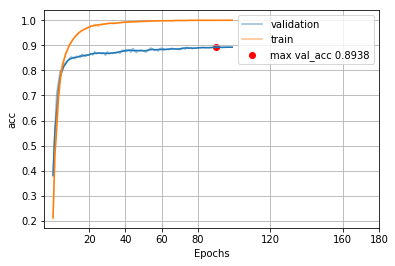

2.2320000000000007

In [15]:
show_result(h)
100 * (1-0.97768)

| dataset | val error | test error | test error+DA   |
|---------|-----------|------------|-----------------|
|  MB     |  0.50     |    0.90    |     0.68        |
|  MBI    |  1.58     |    2.27    |     2.22        |

In [33]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

50000/50000 [==============================] - 35s 693us/step
Test loss: 0.1026977105951158
Test accuracy: 0.9766
